In [1]:
#autoreload
%load_ext autoreload

%autoreload 2

import sys
sys.path.append('../')
import torch
import numpy as np

import dataset
import json

from pl_model import SegmentadorMonoclase
import os
from glob import glob
import matplotlib.pyplot as plt

In [2]:
json_normalizacion="../modelos/normalization_rayosX.json"
# Read json normalization file
with open(json_normalizacion, 'r') as file:
    normalizacion = json.load(file)


media= normalizacion["medias_norm"]
dstd= normalizacion["stds_norm"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
def normalizacion_imagen(imgtensor,normalizacion):
    media=torch.tensor(normalizacion['medias_norm']).unsqueeze(1).unsqueeze(2)
    dstd=torch.tensor(normalizacion['stds_norm']).unsqueeze(1).unsqueeze(2)
    imgnormalizado =(imgtensor-media)
    return imgnormalizado

def predict_image(imgname,normalizacion,modelo,device):
    if isinstance(imgname,str):
        imgtensor = dataset.read_image_rayosX(imgname,2**16-1)
    else:
        imgtensor=imgname
    
    imgnormalizado=imgtensor
    imgnormalizado=imgnormalizado.unsqueeze(0).to(device)
   
    modelo.eval()
    with torch.no_grad():
         logits = modelo(imgnormalizado)
    logits= logits[0,0,:,:]
    probs=torch.nn.functional.sigmoid(logits)
    probs=probs.cpu().numpy()         
    return probs

In [4]:
modelo= SegmentadorMonoclase(
                            optimizer = 'sgd',  
                            num_channels_in=3,
                            model_version="deeplabv3_resnet50 ",
                          )
fichmodelo="../out_models/segmentadorRayosX.ckpt"
checkpoint = torch.load(fichmodelo)
modelo.load_state_dict(checkpoint['state_dict'])
_=modelo.to(device)


SegmentadorMonoclase Num epochs: None

***** Warning. Version  solicitada deeplabv3_resnet50  no contemplada. Usando deeplabv3_resnet50
MODEL NUM CHHANELS IN 3
DeepLab Num channels_in: 3


In [5]:
usuario=os.getenv('USER')
home=os.getenv('HOME')
mscanData= home + '/owc/mscanData/' if usuario == 'aalbiol' else home + 'mscanData/'

dir_recortes_in=mscanData + 'rayosX/pollo/recortes_good/'
input_files=glob(dir_recortes_in + '*estigo*.png')
print('Number of input files:', len(input_files))   
print('First file:', input_files[0])

Number of input files: 153
First file: /home/aalbiol/owc/mscanData/rayosX/pollo/recortes_good/LOWentremusloTestigos_00008.png


In [6]:
imgtensor=imgtensor = dataset.read_image_rayosX(input_files[17],2**16-1)
print('Image tensor shape:', imgtensor.shape)
print('Image tensor mean:', imgtensor.mean(dim=(1,2)))



Image tensor shape: torch.Size([3, 674, 431])
Image tensor mean: tensor([0.643, 0.666, 0.619])


In [8]:
root_folder="/home/aalbiol/owc/mscanData/rayosX/pollo"
train_dataset=("../listas_rayosX/buenos/train/train_list.txt","recortes_good")
sim_params={
    'prob_no_change':-1,
    'min_number_of_defects':5,
    'max_number_of_defects':24,
    'min_defect_intensity':0.05,
    'max_defect_intensity': 0.1,
    'min_defect_size':5,
    'max_defect_size':30,
    'min_defect_width':2,
    'max_defect_width':4,
}

ds=dataset.DataplacesDataSet(root_folder=root_folder,dataplaces=[train_dataset], 
                             max_values=[2**16-1,2**16-1,2**16-1],delimiter=".",terminaciones=[".png"],
                             params_simulacion_defectos=sim_params,transform=None,normalization_image_size=(700,700))

>>>>>>>>>> Image size in DataSet (700, 700)
Datos de normalizacion calculados y guardados en modelos/normalization.json


['/home/aalbiol/owc/mscanData/rayosX/pollo/recortes_good/LOWentremusloGood_00085.png']


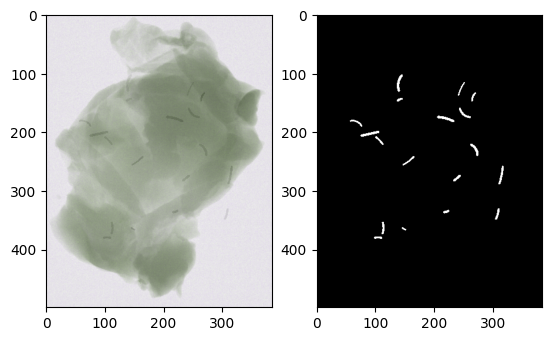

In [9]:
im,nombre,mask=ds.__getitem__(0)
print(nombre)
_=plt.subplot(1,2,1)
_=plt.imshow(im.permute((1,2,0)).numpy(),cmap="gray",clim=[0,1])
_=plt.subplot(1,2,2)
_=plt.imshow(mask.numpy(),cmap="gray",clim=[0,1])


In [18]:
type(im),im.shape

(torch.Tensor, torch.Size([3, 499, 385]))

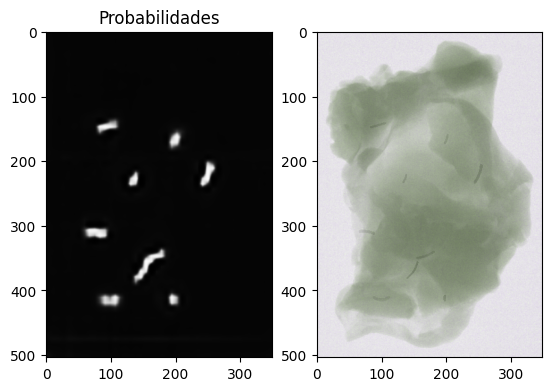

In [20]:
k=1
im,nombre,mask=ds.__getitem__(k)
probs=predict_image(im,normalizacion,modelo,device)
_=plt.subplot(1,2,1)
_=plt.imshow(probs,clim=(0,1),cmap='gray')
_=plt.title('Probabilidades')
_=plt.subplot(1,2,2)
plt.imshow(im.permute((1,2,0)).numpy())


AttributeError: 'numpy.ndarray' object has no attribute 'read'

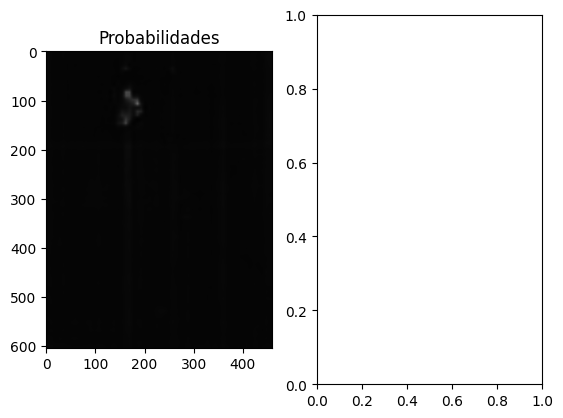

In [12]:
k=2
probs=predict_image(input_files[k],normalizacion,modelo,device)
_=plt.subplot(1,2,1)
_=plt.imshow(probs,clim=(0,1),cmap='gray')
_=plt.title('Probabilidades')
_=plt.subplot(1,2,2)
img= plt.imshow(im.permute((1,2,0)).detach().cpu().numpy())


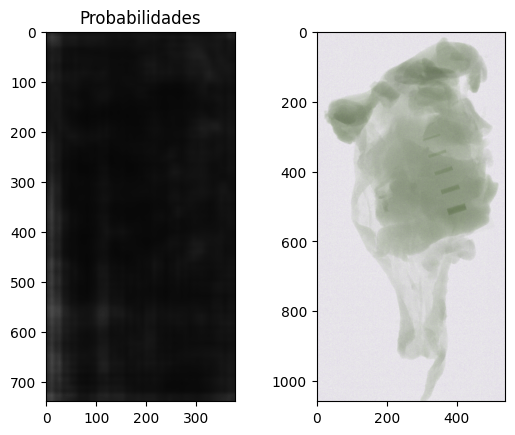

In [18]:
k=33
probs=predict_image(input_files[k],normalizacion,modelo,device)
_=plt.subplot(1,2,1)
_=plt.imshow(probs,clim=(0,1),cmap='gray')
_=plt.title('Probabilidades')
_=plt.subplot(1,2,2)
img= plt.imread(input_files[k])
_=plt.imshow(img)